In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

seaborn 0.10.1
pandas  1.0.4
numpy   1.18.4



In [2]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5037974/
inf_truth = "/mnt/nvidia/pkr/code/type_1/data/mock_communities/mbarc_26/SRR3656745/mbarc_26_truth.txt"
inf_tax_file = "/mnt/btrfs/data/rep202/ab/taxmap.tsv"
outf_truth = "/mnt/nvidia/pkr/code/type_1/data/mock_communities/mbarc_26/SRR3656745/mbarc_26_truth_rg.txt"

inf_coverage = "/mnt/nvidia/pkr/code/type_1/data/mock_communities/mbarc_26/SRR3656745/filter/coverage-201029.txt"

In [3]:
!rg Sediminispirochaeta_smaragdinae {inf_tax_file}

11410:GCF_000143985.1	k__Bacteria;p__Spirochaetes;c__Spirochaetia;o__Spirochaetales;f__Spirochaetaceae;g__Sediminispirochaeta;s__Sediminispirochaeta_smaragdinae


In [4]:
with open(outf_truth, "w") as outf:
    with open(inf_truth) as inf:
        for query in inf:
            query = query.rstrip()
            results = !rg {query} {inf_tax_file}
            if len(results) == 0:
                print(query)
            for result in results:
                outf.write(result + "\n")

In [5]:
df_inf_coverage = pd.read_csv(inf_coverage, sep="\t")
headers = list(df_inf_coverage.columns)
headers[0] = "tax"
df_inf_coverage.columns = headers

In [6]:
df_inf_coverage["hits_in_clade"].median()

8.0

In [7]:
df_truth = pd.read_csv(outf_truth, header=None, sep="\t")

df_truth.columns = ["id", "tax"]
df_truth["species"] = [";".join(s.split(";")[:7]) for s in df_truth["tax"]]
s_truth = set(df_truth["species"])
df_inf_coverage["truth"] = [species in s_truth for species in df_inf_coverage.tax]
df_inf_coverage["truth"].sum()
len(s_truth)

26

In [8]:
# print the species not in mock
s_inf = set(df_inf_coverage.loc[df_inf_coverage["truth"], "tax"])
s_truth.difference(s_inf)

set()

In [9]:
# we might want to drop all viruses and plasmids for this analysis

mask_plasmids = df_inf_coverage["tax"].apply(lambda x: "plasmid" in x.lower())
mask_virus = df_inf_coverage["tax"].apply(lambda x: "virus" in x.lower())

df_masked = df_inf_coverage.loc[(~(mask_plasmids | mask_virus))].copy()

In [10]:
df_masked[df_masked["truth"]]

,tax,max_uncovered_region,percent_max_uncovered_region,percent_of_genome_covered,median_genome_size,hits_in_clade,unique_counts_of_clade,expected_coverage,ratio_covered_over_expected,truth
163,k__Archaea;p__Euryarchaeota;c__Halobacteria;o_...,473.0,0.01446,0.98554,32713.0,879364.0,32240.0,1.00000,0.98554,True
182,k__Archaea;p__Euryarchaeota;c__Halobacteria;o_...,2772.0,0.06818,0.93182,40657.0,1347514.0,39904.0,1.00000,0.93182,True
186,k__Archaea;p__Euryarchaeota;c__Halobacteria;o_...,782.0,0.01780,0.98220,43925.0,2349913.0,43336.0,1.00000,0.98220,True
251,k__Bacteria;p__Acidobacteria;c__Acidobacteriia...,19610.0,0.40383,0.00132,48560.0,1520.0,48523.0,0.03084,0.04274,True
392,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,1964.0,0.05676,0.70266,34604.0,107402.0,32619.0,0.96285,0.72978,True
812,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,331.0,0.01037,0.98956,31908.0,631721.0,31674.0,1.00000,0.98956,True
1987,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,16149.0,0.22291,0.00041,72447.0,15.0,67136.0,0.00022,1.85358,True
2082,k__Bacteria;p__Actinobacteria;c__Coriobacterii...,344.0,0.01591,0.88327,21622.0,1246277.0,21538.0,1.00000,0.88327,True
2212,k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__...,5575.0,0.09042,0.90958,61657.0,476381.0,57347.0,0.99975,0.90980,True
2501,k__Bacteria;p__Deinococcus-Thermus;c__Deinococ...,43380.0,0.53822,0.46178,80599.0,17825608.0,78095.0,1.00000,0.46178,True


In [11]:
df_masked.loc[df_masked["truth"], "percent_of_genome_covered"].mean()

0.6808469230769231

In [12]:
df_masked.loc[~df_masked["truth"], "percent_of_genome_covered"].mean()

0.0008794022925764192

In [13]:
df_masked.groupby("truth").mean()

,max_uncovered_region,percent_max_uncovered_region,percent_of_genome_covered,median_genome_size,hits_in_clade,unique_counts_of_clade,expected_coverage,ratio_covered_over_expected
truth,,,,,,,,
False,39200.580786,0.758625,0.000879,52879.797489,5.620948e+02,44784.887009,0.007289,1.089221
True,14776.076923,0.189616,0.680847,54166.230769,2.912211e+06,46561.384615,0.869618,0.768818


In [14]:
import lightgbm

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [36]:
X = df_masked.loc[:, df_masked.columns.difference(["truth", "tax", "ratio_covered_over_expected"])]
y = df_masked["truth"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#
# Create the LightGBM data containers
#
# categorical_features = [c for c, col in enumerate(train.columns) if 'cat' in col]
# train_data = lightgbm.Dataset(x, label=y, categorical_feature=categorical_features)
train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)

In [37]:
#
# Train the model
#

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

lgb = lightgbm.LGBMClassifier(**parameters)
lgb.fit(X_train, y_train)

LGBMClassifier(application='binary', bagging_fraction=0.5, bagging_freq=20,
               boosting='gbdt', feature_fraction=0.5, is_unbalance='true',
               learning_rate=0.05, metric='auc', objective='binary', verbose=0)

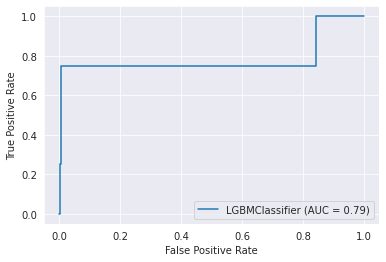

In [38]:
lgb_disp = plot_roc_curve(lgb, X_test, y_test)
plt.show()

 97%|=================== | 5364/5515 [00:24<00:00]       

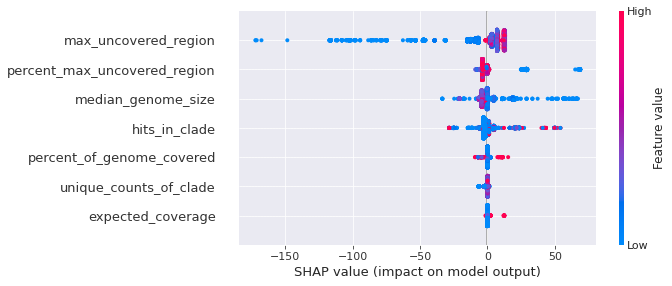

In [40]:
explainer = shap.TreeExplainer(lgb, X_train)

shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, show=False)
fig = plt.gcf()

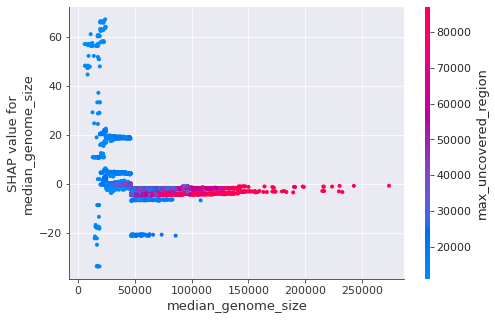

In [41]:
shap.dependence_plot("median_genome_size", shap_values, X_train)

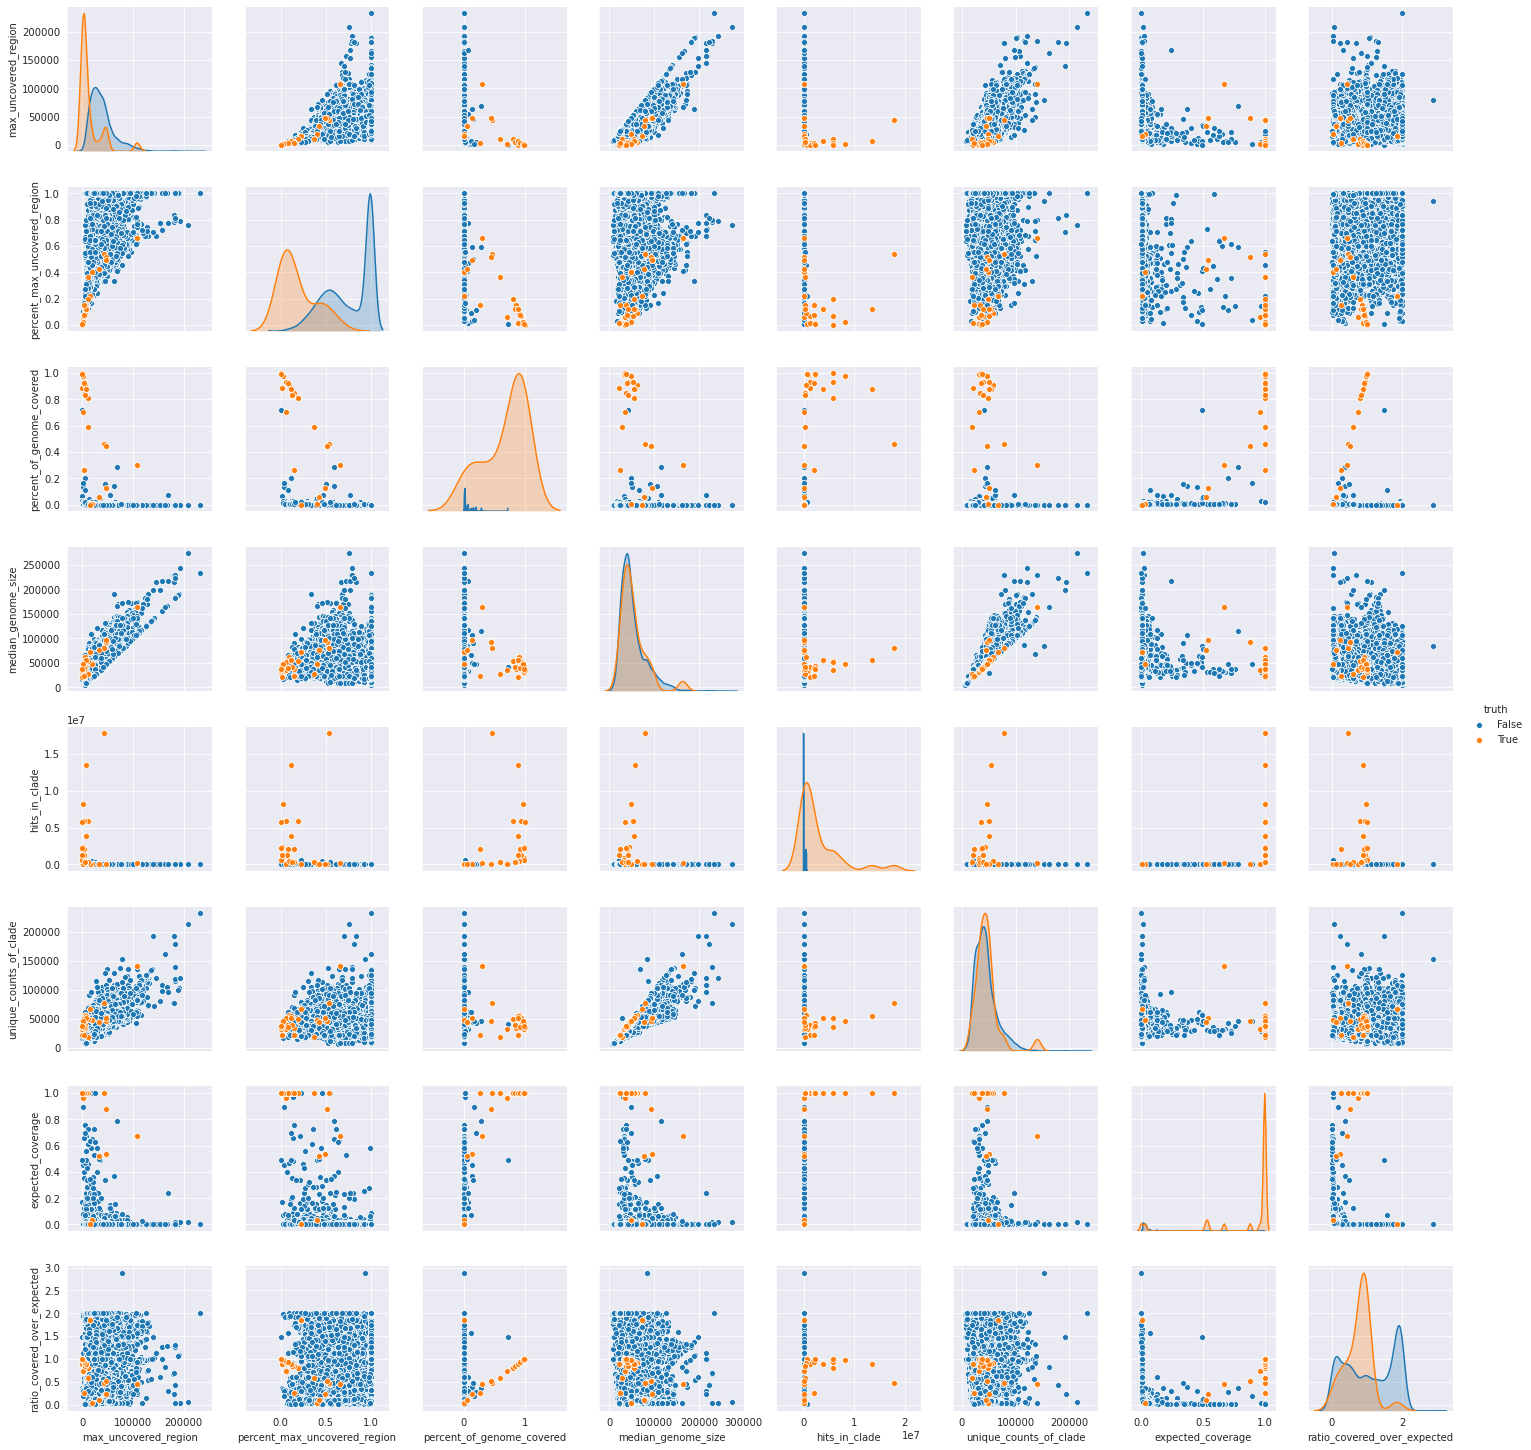

In [42]:
sns.pairplot(df_masked, hue="truth")

In [19]:
sum(lgb.predict(X))

378

In [20]:
X[lgb.predict_proba(X)[:, 1]  > .75]

,expected_coverage,hits_in_clade,max_uncovered_region,median_genome_size,percent_of_genome_covered,unique_counts_of_clade
163,1.00000,879364.0,473.0,32713.0,0.98554,32240.0
182,1.00000,1347514.0,2772.0,40657.0,0.93182,39904.0
186,1.00000,2349913.0,782.0,43925.0,0.98220,43336.0
392,0.96285,107402.0,1964.0,34604.0,0.70266,32619.0
497,0.00051,50.0,51621.0,108606.0,0.00020,98597.0
...,...,...,...,...,...,...
7290,0.00000,1.0,232606.0,232608.0,0.00001,232499.0
7328,0.99861,142320.0,3743.0,22603.0,0.02132,21628.0
7329,0.99995,291998.0,24917.0,44939.0,0.02250,29756.0
7331,1.00000,2083245.0,3658.0,24220.0,0.25995,21803.0


In [21]:
predictions = lgb.predict_proba(X)

In [22]:
predictions[:i]

NameError: name 'i' is not defined

In [ ]:
df_masked.shape

In [ ]:
df_masked.loc[predictions[:, 1] >= .5, ["tax", "truth"]].shape

In [ ]:
for i in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:
    print(y[predictions[:, 1] > i].sum() / (predictions[:, 1] > i).sum())
print(df_masked.loc[predictions[:, 1] > .5, ["tax", "truth"]].values)